In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os

Read input data

In [3]:
shops = pd.read_csv("data/shops.csv")
item_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")

test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
train_master = sales_train.merge(items, on='item_id').merge(shops, on='shop_id').merge(item_categories, on='item_category_id')
train_master['city'] = train_master['shop_name'].str.split(' ').map(lambda x : x[0])
train_master.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль


## Feature Engineering

Aggregate sales to monthly level and clip the value

In [48]:
# Aggregate the sales by month
train = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
train.columns = ['item_cnt_sum']
train.reset_index(inplace=True)

Let's look at the statistics for the target variable

In [50]:
train['item_cnt_sum'].describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_sum, dtype: float64

There are some values that are too large. Let's try clipping the values to [0, 20]

In [51]:
train['item_cnt_sum'] = np.clip(train['item_cnt_sum'], 0, 20)

Notice that we do not have all the (date_block_num, shop_id, item_id) pairs, if the sales = 0. Therefore, we need to fill in the missing pairs.

In [52]:
months = train['date_block_num'].unique()

cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))
    
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)
print(cartesian_df.shape)

(10913850, 3)


The generated cartesian_df dataframe will contain all the unique (shop_id, item_id, date_block_num) pairs

We merge it back to the train dataframe and fill NaN with zeros to include zeros in the sales record

In [53]:
new_train = cartesian_df.merge(train, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_sum
0,0,32,0,6.0
1,0,33,0,3.0
2,0,35,0,1.0
3,0,43,0,1.0
4,0,51,0,2.0


In [54]:
new_train = new_train.merge(items, on='item_id').merge(shops, on='shop_id').merge(item_categories, on='item_category_id')
new_train['city'] = new_train['shop_name'].str.split(' ').map(lambda x : x[0])

new_train.sort_values(by=['date_block_num', 'shop_id', 'item_id'], inplace=True)
new_train.reset_index(drop=True, inplace=True)

In [56]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_sum,item_name,item_category_id,shop_name,item_category_name,city
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,!Якутск
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,"!Якутск Орджоникидзе, 56 фран",Игры - PS3,!Якутск
2,0,28,0,0.0,"007 Legends [PС, Jewel, русская версия]",30,"!Якутск Орджоникидзе, 56 фран",Игры PC - Стандартные издания,!Якутск
3,0,29,0,0.0,"007 Legends [Xbox 360, русская версия]",23,"!Якутск Орджоникидзе, 56 фран",Игры - XBOX 360,!Якутск
4,0,32,0,6.0,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,!Якутск


### Add features: item_id related features <br>
- item_id
- shop_id
- name of the item (?)
- last month's sale
- last year's sale
- whether is on promotion (?)

In [57]:
def lag_feature(df, df_shift, lags, on, col):
    tmp = df_shift[on + [col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = on + [col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, on=on, how='left')
    return df

In [58]:
new_train = lag_feature(new_train, new_train, lags=[1, 3, 6, 12], on=['date_block_num','shop_id','item_id'], col='item_cnt_sum')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_name,item_category_id,shop_name,item_category_name,city,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,!Якутск,NaN,NaN,NaN,NaN
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,"!Якутск Орджоникидзе, 56 фран",Игры - PS3,!Якутск,NaN,NaN,NaN,NaN


### Add features: Categorical related features <br>
- item_category_id
- last month's sale for the same item_category_id
- last year's sale for the same item_category_id

In [59]:
df = train_master.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_day':['sum']})
df.columns = ['item_cnt_by_cat_sum']
df.reset_index(inplace=True)
df.head(2)

,date_block_num,shop_id,item_category_id,item_cnt_by_cat_sum
0,0,0,2,53.0
1,0,0,3,28.0


In [60]:
new_train = lag_feature(new_train, df, lags=[1,3,6,12], on=['date_block_num','shop_id','item_category_id'], col='item_cnt_by_cat_sum')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_name,item_category_id,shop_name,item_category_name,city,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,item_cnt_by_cat_sum_lag_1,item_cnt_by_cat_sum_lag_3,item_cnt_by_cat_sum_lag_6,item_cnt_by_cat_sum_lag_12
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,"!Якутск Орджоникидзе, 56 фран",Игры - PS3,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add features: month and city label

Add a month feature

In [61]:
new_train['month'] = new_train['date_block_num'] % 12

Label encode the categorical variables

In [62]:
from sklearn import preprocessing

In [63]:
le = preprocessing.LabelEncoder()
new_train['city_label'] = le.fit_transform(new_train['city'])
new_train.drop(['shop_name', 'city'], axis = 1, inplace=True)
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_name,item_category_id,item_category_name,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,item_cnt_by_cat_sum_lag_1,item_cnt_by_cat_sum_lag_3,item_cnt_by_cat_sum_lag_6,item_cnt_by_cat_sum_lag_12,month,city_label
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [64]:
new_train.to_pickle('train.pkl')

## Build an XGBoost Model

Training set and evaluation set split: <br>
- training set: date_block_num in range(12, 33)
- validation set: date_block_num == 33

In [65]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 32)]
x_val = new_train[new_train.date_block_num == 33]

In [66]:
y_train = x_train[['item_cnt_sum']]
y_val = x_val[['item_cnt_sum']]
x_train = x_train.drop(columns=['item_name', 'item_category_name', 'item_cnt_sum'])
x_val = x_val.drop(columns=['item_name', 'item_category_name', 'item_cnt_sum'])

Check NaN values. They are essentially zero values (no lag sales record), so let's fill them with zeros

In [67]:
x_train.isna().sum()

shop_id                             0
item_id                             0
date_block_num                      0
item_category_id                    0
item_cnt_sum_lag_1            1288325
item_cnt_sum_lag_3            1658858
item_cnt_sum_lag_6            2201695
item_cnt_sum_lag_12           3280022
item_cnt_by_cat_sum_lag_1     1041911
item_cnt_by_cat_sum_lag_3     1107928
item_cnt_by_cat_sum_lag_6     1214648
item_cnt_by_cat_sum_lag_12    1472286
month                               0
city_label                          0
dtype: int64

In [36]:
x_val.isna().sum()

shop_id                            0
item_id                            0
date_block_num                     0
item_category_id                   0
item_cnt_sum_lag_1             72491
item_cnt_sum_lag_3             85775
item_cnt_sum_lag_6             98690
item_cnt_sum_lag_12           125555
item_cnt_by_cat_sum_lag_1      56776
item_cnt_by_cat_sum_lag_3      56868
item_cnt_by_cat_sum_lag_6      59495
item_cnt_by_cat_sum_lag_12     58665
month                              0
city_label                         0
dtype: int64

In [68]:
y_train.isna().sum()

item_cnt_sum    0
dtype: int64

In [69]:
y_val.isna().sum()

item_cnt_sum    0
dtype: int64

In [70]:
x_train = x_train.fillna(0.0)

In [71]:
x_val = x_val.fillna(0.0)

Let's try an XGBoost model!

In [72]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [73]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    min_child_weight=300, 
    colsample_bytree=0.5, 
    subsample=0.5)
    #eta=0.3,    
    #seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[22:45:23] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.158	validation_1-rmse:1.1242
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13344	validation_1-rmse:1.10225
[2]	validation_0-rmse:1.11048	validation_1-rmse:1.08166
[3]	validation_0-rmse:1.07535	validation_1-rmse:1.0552
[4]	validation_0-rmse:1.0641	validation_1-rmse:1.04422
[5]	validation_0-rmse:1.05077	validation_1-rmse:1.03355
[6]	validation_0-rmse:1.03638	validation_1-rmse:1.0235
[7]	validation_0-rmse:1.02686	validation_1-rmse:1.01559
[8]	validation_0-rmse:1.01907	validation_1-rmse:1.00883
[9]	validation_0-rmse:1.01245	validation_1-rmse:1.00344
[10]	validation_0-rmse:0.992749	validation_1-rmse:0.990359
[11]	validation_0-rmse:0.976362	validation_1-rmse:0.9805

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=300, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

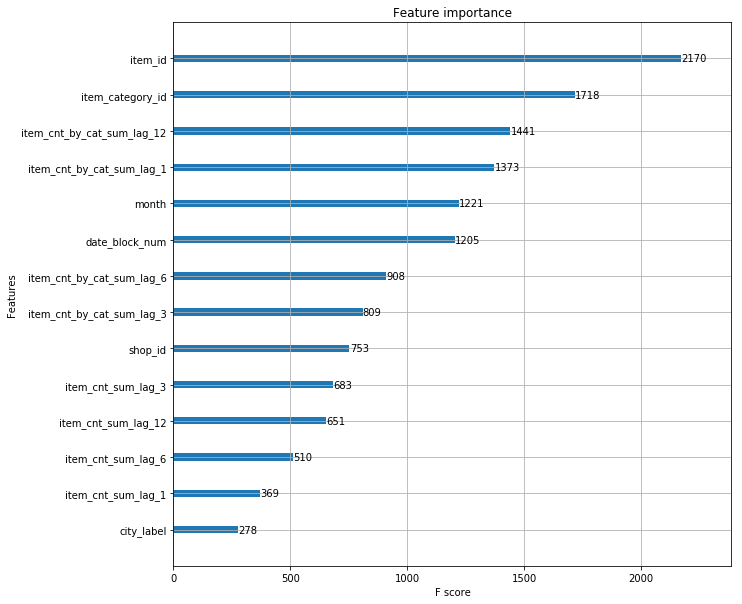

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model, ax=ax)

In [77]:
import pickle

pickle.dump(model, open('model.Jun17.dat','wb'))